In [39]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.uncertainty_measures import calculate_uncertainties
from source.utils.metrics import auroc, aupr, fpr_at_tpr_x
from source.data.cifar10_c import corruptions

os.makedirs(PLOTS_PATH, exist_ok=True)

In [40]:
seed = 42

methods = ["deep_ensemble", "laplace", "mc_dropout"]
models = ["resnet18", "densenet169", "regnet"]

method = methods[0]                         # select method 
metric = [auroc, aupr, fpr_at_tpr_x][0]     # select metric 
model = models[0]                           # select model 

p_drop = 0.2                                # dropout rate of MC dropout     

runs = 5                                    # number of runs
n_classes = 10                              # number of classes
n_corruptions = 15                          # number of corruptions
n_severities = 5                            # number of severities

print(method, model, metric.__name__)

deep_ensemble resnet18 auroc


In [41]:
if method == "deep_ensemble":
    path = os.path.join(RESULTS_PATH, f"cifar10_{model}_seed{seed}")
    c_path = os.path.join(RESULTS_PATH, f"cifar10_{model}_seed{seed}", "corruptions")
elif method == "laplace":
    path = os.path.join(RESULTS_PATH, f"cifar10_{model}_seed{seed}_laplace")
    c_path = os.path.join(RESULTS_PATH, f"cifar10_{model}_seed{seed}_laplace", "corruptions")
elif method == "mc_dropout":
    path = os.path.join(RESULTS_PATH, f"cifar10_{model}_dropout{p_drop}_seed{seed}")
    c_path = os.path.join(RESULTS_PATH, f"cifar10_{model}_dropout{p_drop}_seed{seed}", "corruptions")
else:
    raise ValueError("Invalid method")

probits = list()
for c in range(15):
    probits.append(list())
    for s in range(1, 6):
        p = torch.load(os.path.join(c_path, f"{corruptions[c]}_{s}_probits.pt")).to(torch.float32)
        probits[c].append(p.reshape(len(p), runs, -1, n_classes))
    probits[c] = torch.stack(probits[c], dim=1)
probits = torch.stack(probits, dim=1)


clean_probits = torch.load(os.path.join(path, f"cifar10_probits.pt")).to(torch.float32)
clean_probits = clean_probits.reshape(len(clean_probits), runs, -1, n_classes)
y_test = torch.load(os.path.join(path, f"cifar10_ys.pt"))

clean_uncertainties = calculate_uncertainties(clean_probits, clean_probits)
uncertainties = calculate_uncertainties(probits, probits)

print(clean_probits.shape)
print(clean_uncertainties["A1"][0].shape)
print(probits.shape)
print(uncertainties["A1"][0].shape)

torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5])
torch.Size([10000, 15, 5, 5, 10, 10])
torch.Size([10000, 15, 5, 5])


In [42]:
def evaluate(clean_uncertainties, uncertainties, metric, runs, dataset_name, verbose=True):
    
    unc_names = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"]
    all_perfs = list()

    if verbose: 
        print("Unc. ", end="")
        for unc_name in unc_names:
            print(f"& {unc_name} ", end="")
        print(" \\\\")
        print(f"\\hline & \\multicolumn{'{9}{c}{'}{dataset_name.upper()}{'}'} \\\\ \\cline{'{2-10}'} ")

    for u, unc in enumerate(["TU", "AU", "EU"]):
        if verbose: print(f"{unc} ", end="")
        for measure in unc_names:
            if unc == "EU" and measure == "B2":
                continue # B2 is not defined for epistemic uncertainty
            scores = torch.concat((clean_uncertainties[measure][u], uncertainties[measure][u]), dim=0)
            perfs = list()
            for r in range(runs):
                ys = torch.ones(size=(len(scores), ), dtype=torch.long)
                ys[:len(scores) // 2] = 0
                perf = metric(scores[:, r], ys).item() * 100
                perfs.append(perf)
            mean_str = f"{np.mean(perfs):.2f}"
            std_str = f"{np.std(perfs):.2f}"
            if verbose: print(f"& ${mean_str}_{'{'}\pm {std_str}{'}'}$ ", end="")
            all_perfs.append(perfs)
        if verbose: print(" \\\\")

    return torch.tensor(all_perfs).moveaxis(0, 1)

In [43]:
all_perfs = list()
for c in range(n_corruptions):
    for s in range(1, n_severities + 1):
        unc_ = {k: [u[:, c, s - 1] for u in v] for k, v in uncertainties.items()}
        perfs = evaluate(clean_uncertainties, unc_, metric, runs, f"{corruptions[c]} - {s}", verbose=False)
        all_perfs.append(perfs)
all_perfs = torch.stack(all_perfs, dim=0).reshape(n_corruptions, n_severities, runs, -1)

print(all_perfs.shape)

torch.Size([15, 5, 5, 26])


In [44]:
def adjust_inset_axis(inset_ax, ymin, ymax):
    inset_ax.set_xticks([])
    # inset_ax.set_yticks([])
    inset_ax.tick_params(axis='y', which='both', labelsize=10, pad=-3)
    inset_ax.set_ylim(ymin, ymax)
    inset_ax.set_title("Severity - 5", fontsize=12)
    # black border
    inset_ax.spines['bottom'].set_color('black')
    inset_ax.spines['top'].set_color('black')
    inset_ax.spines['right'].set_color('black')
    inset_ax.spines['left'].set_color('black')

def plot(data, title, name:str = None):

    tu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#DD8452", "#CC6333"]
    au_colors = ["#5D8CD8", "#DD8452", "#55A868"]
    eu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#CC6333", "#85BF91", "#55A868", "#418050"]

    # tu_colors = au_colors = eu_colors = sns.color_palette("deep")


    tu_labels = ["A1", "A2", "A3", "B/C1", "B/C2", "B/C3"]
    au_labels = ["A", "B", "C"]
    eu_labels = ["A1", "A2", "A3", "B1", "B3", "C1", "C2", "C3"]

    f, axs = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)

    inset_ax_0 = inset_axes(axs[0], width="30%", height="35%", loc="upper right" if metric == fpr_at_tpr_x else 'lower right')
    for i in range(len(tu_labels)):
        axs[0].plot(range(1, n_severities + 1), data[..., i].mean(dim=1), marker="o", label=tu_labels[i], color=tu_colors[i])
        axs[0].fill_between(range(1, n_severities + 1), 
                            data[..., i].mean(dim=1) - data[..., i].std(dim=1), 
                            data[..., i].mean(dim=1) + data[..., i].std(dim=1), color=tu_colors[i], alpha=0.3)
        inset_ax_0.bar(tu_labels[i], data[-1, :, i].mean(), yerr=data[-1, :, i].std(), color=tu_colors[i], label=tu_labels[i], linewidth=0)
    axs[0].legend(title="TU", fontsize=10, title_fontsize=12, loc="lower left" if metric == fpr_at_tpr_x else "upper left")

    inset_ax_1 = inset_axes(axs[1], width="30%", height="35%", loc="upper right" if metric == fpr_at_tpr_x else 'lower right')
    for i in range(len(au_labels)):
        tl = 9
        axs[1].plot(range(1, n_severities + 1), data[..., tl + i * 3].mean(dim=1), marker="o", label=au_labels[i], color=au_colors[i])
        axs[1].fill_between(range(1, n_severities + 1), 
                            data[..., tl + i * 3].mean(dim=1) - data[..., tl + i * 3].std(dim=1), 
                            data[..., tl + i * 3].mean(dim=1) + data[..., tl + i * 3].std(dim=1), color=au_colors[i], alpha=0.3)
        inset_ax_1.bar(au_colors[i], data[-1, :, tl + i * 3].mean(), yerr=data[-1, :, tl + i * 3].std(), color=au_colors[i], label=au_colors[i], linewidth=0)
    axs[1].legend(title="AU", fontsize=10, title_fontsize=12, loc="lower left" if metric == fpr_at_tpr_x else "upper left")

    inset_ax_2 = inset_axes(axs[2], width="30%", height="35%", loc="upper right" if metric == fpr_at_tpr_x else 'lower right')
    for i in range(len(eu_labels)):
        tl = 18
        axs[2].plot(range(1, n_severities + 1), data[..., tl + i].mean(dim=1), marker="o", label=eu_labels[i], color=eu_colors[i])
        axs[2].fill_between(range(1, n_severities + 1), 
                            data[..., tl + i].mean(dim=1) - data[..., tl + i].std(dim=1), 
                            data[..., tl + i].mean(dim=1) + data[..., tl + i].std(dim=1), color=eu_colors[i], alpha=0.3)
        inset_ax_2.bar(eu_colors[i], data[-1, :, tl + i].mean(), yerr=data[-1, :, tl + i].std(), color=eu_colors[i], label=eu_colors[i], linewidth=0)
    axs[2].legend(title="EU", fontsize=10, title_fontsize=12, loc="lower left" if metric == fpr_at_tpr_x else "upper left")

    print(data.shape)
    data_range = (data[-1].mean(dim=0) + data[-1].std(dim=0)).max().item() - (data[-1].mean(dim=0) - data[-1].std(dim=0)).min().item()
    ymin=(data[-1].mean(dim=0) - data[-1].std(dim=0)).min().item() - data_range * 0.05
    ymax=(data[-1].mean(dim=0) + data[-1].std(dim=0)).max().item() + data_range * 0.05

    for inset_ax in [inset_ax_0, inset_ax_1, inset_ax_2]:
        adjust_inset_axis(inset_ax, ymin, ymax)
        inset_ax.hlines(data[-1].mean(dim=0).min() if metric == fpr_at_tpr_x else data[-1].mean(dim=0).max(), 
                        inset_ax.get_xlim()[0], inset_ax.get_xlim()[1], color="black", linestyle="--", alpha=0.3)

    for i in range(3):
        x = range(1, n_severities + 1)
        if metric == fpr_at_tpr_x:
            y = [data[s].mean(dim=0).min() for s in range(n_severities)]
        else:
            y = [data[s].mean(dim=0).max() for s in range(n_severities)]
        axs[i].step(x, y, where="mid", color="black", linestyle="--", alpha=0.3)
    
    # Method
    axs[1].text(3, data[-1].mean(dim=0).max(), f"{['DE', 'LA', 'MCD'][methods.index(method)]}", ha="center", va="top",
                       bbox=dict(boxstyle='round, pad=0.3', edgecolor='black', facecolor='white'))
        
    axs[1].set_xlabel("Severity")
    axs[1].set_title(title, fontsize=14)
    axs[0].set_ylabel({auroc: "AUROC", aupr: "AUPR", fpr_at_tpr_x: "FPR95"}[metric])
    plt.tight_layout()
    plt.show()
    if name is not None:
        f.savefig(os.path.join(PLOTS_PATH, f"{name}.pdf"))

In [45]:
# [C, S, R, U]
plt_data = torch.mean(all_perfs, dim=0)
# [S, R, U]

torch.Size([5, 5, 26])


/tmp/ipykernel_4081143/2979420989.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


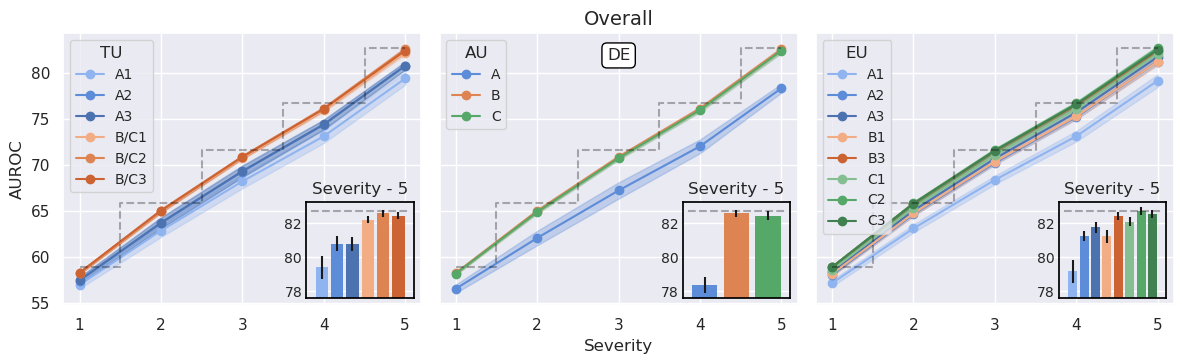

In [46]:
plot(plt_data, "Overall", f"cifar10-c_{method}_{model}_{metric.__name__}_overall")

brightness
torch.Size([5, 5, 26])


/tmp/ipykernel_4081143/2979420989.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


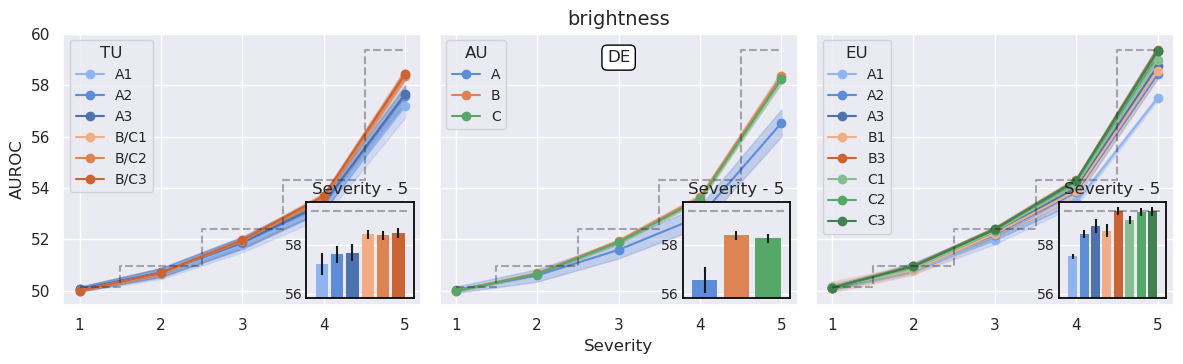

contrast
torch.Size([5, 5, 26])


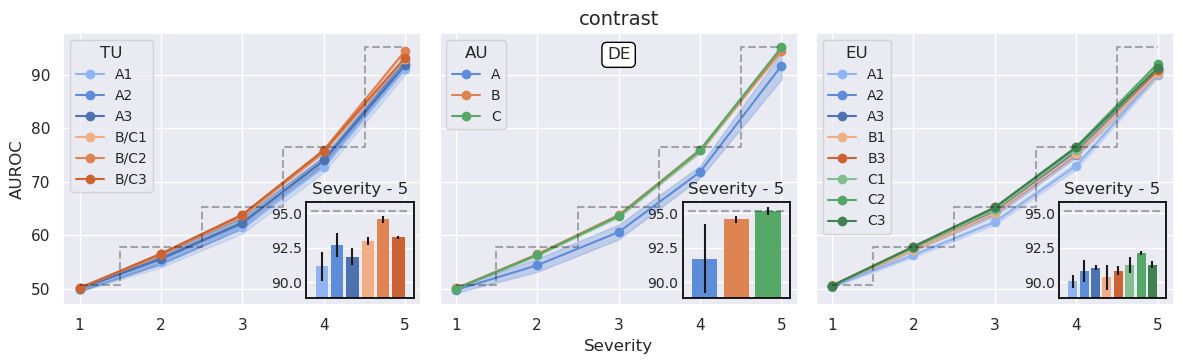

defocus_blur
torch.Size([5, 5, 26])


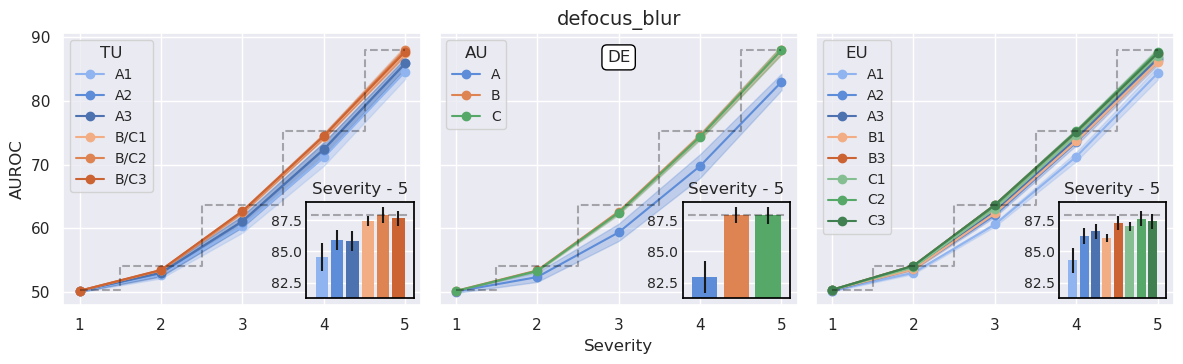

elastic_transform
torch.Size([5, 5, 26])


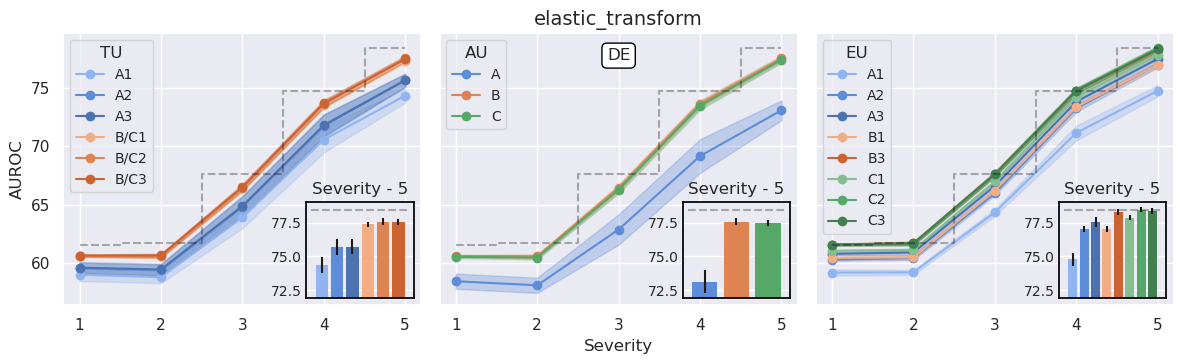

fog
torch.Size([5, 5, 26])


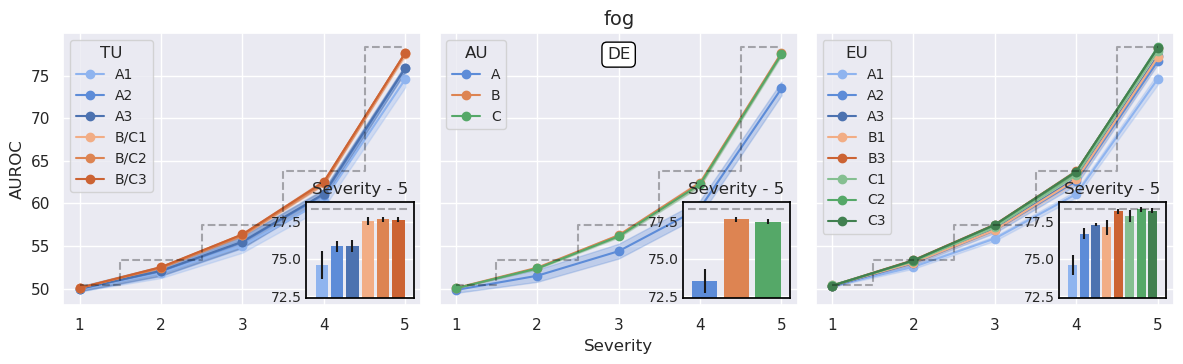

frost
torch.Size([5, 5, 26])


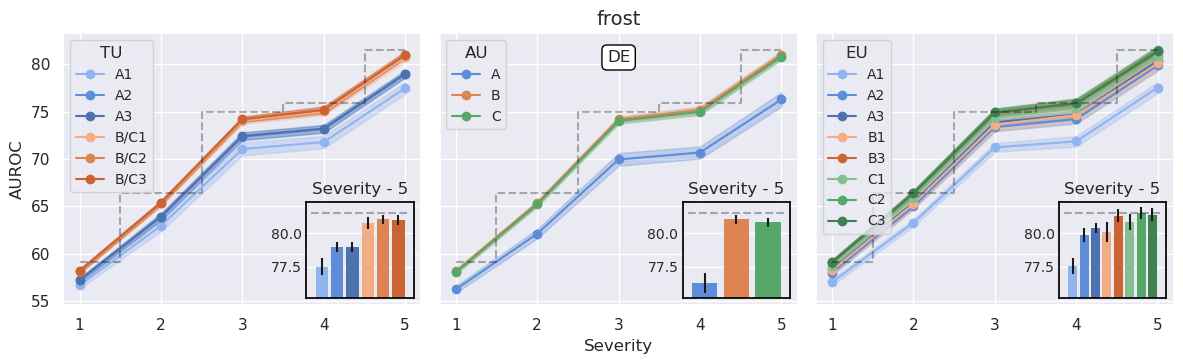

gaussian_blur
torch.Size([5, 5, 26])


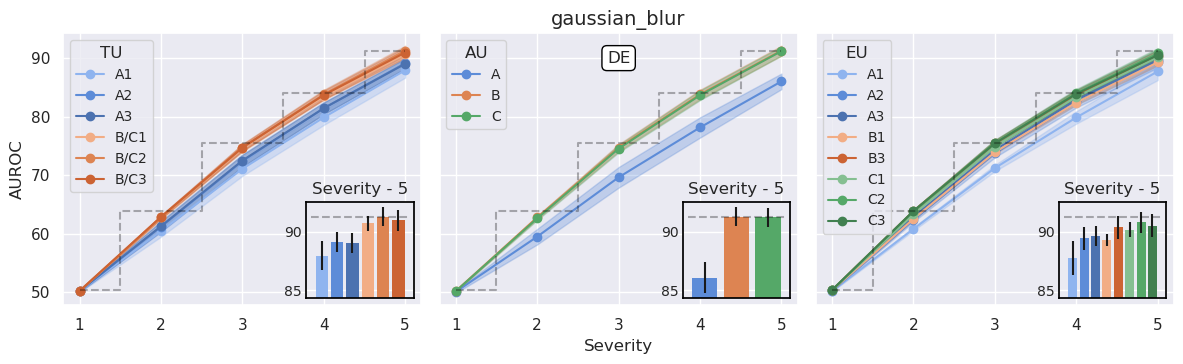

gaussian_noise
torch.Size([5, 5, 26])


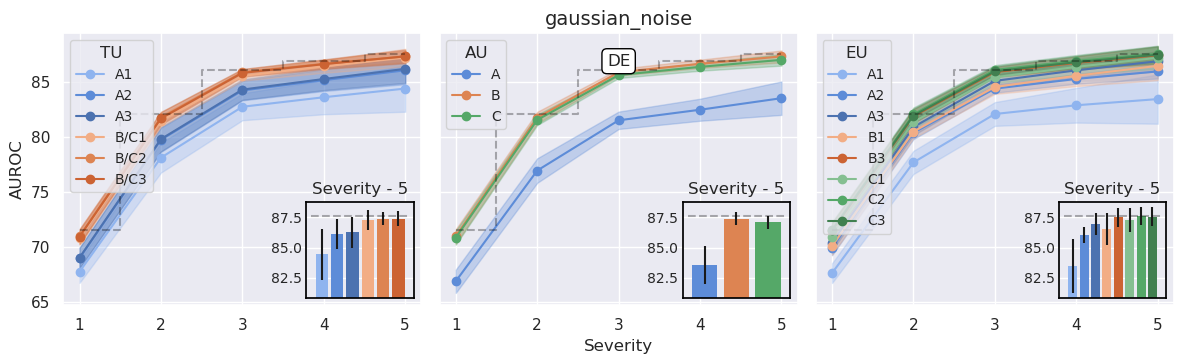

impulse_noise
torch.Size([5, 5, 26])


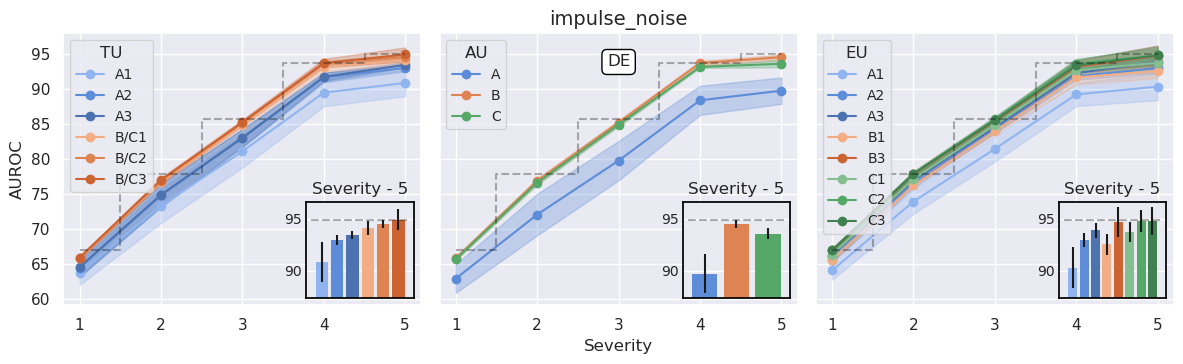

jpeg_compression
torch.Size([5, 5, 26])


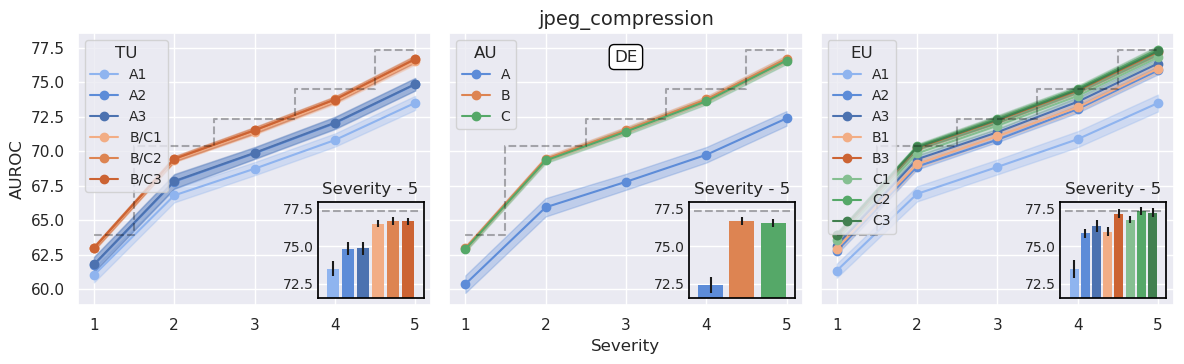

motion_blur
torch.Size([5, 5, 26])


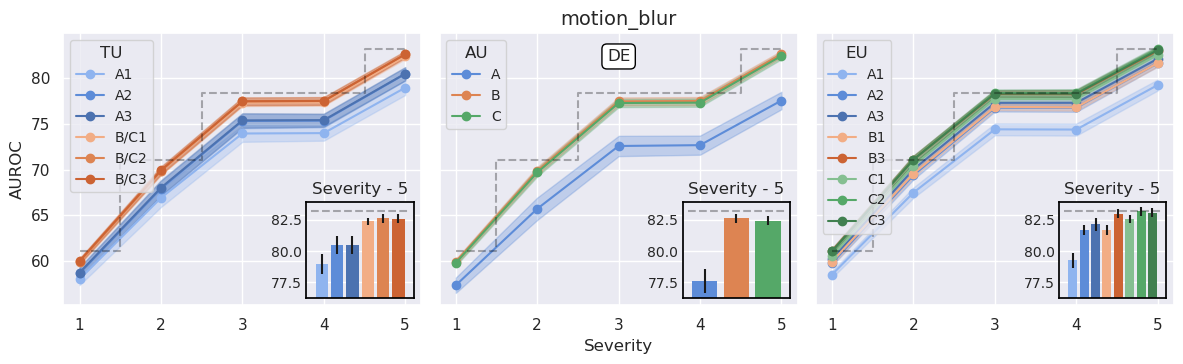

pixelate
torch.Size([5, 5, 26])


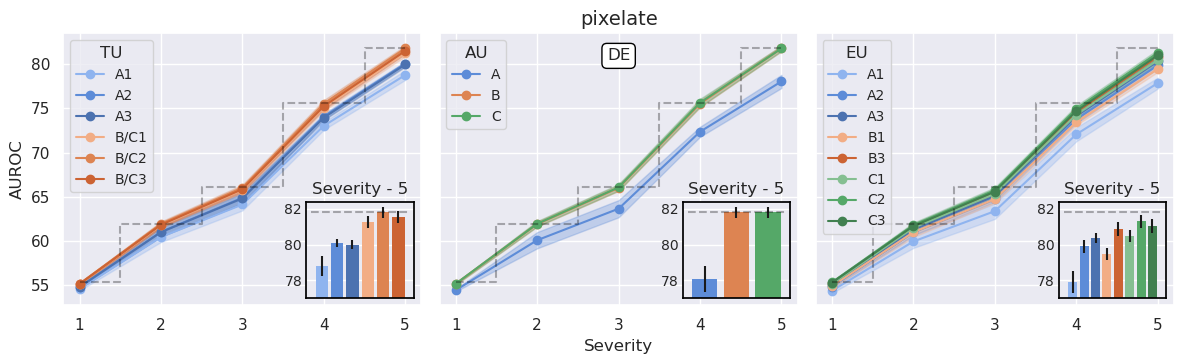

shot_noise
torch.Size([5, 5, 26])


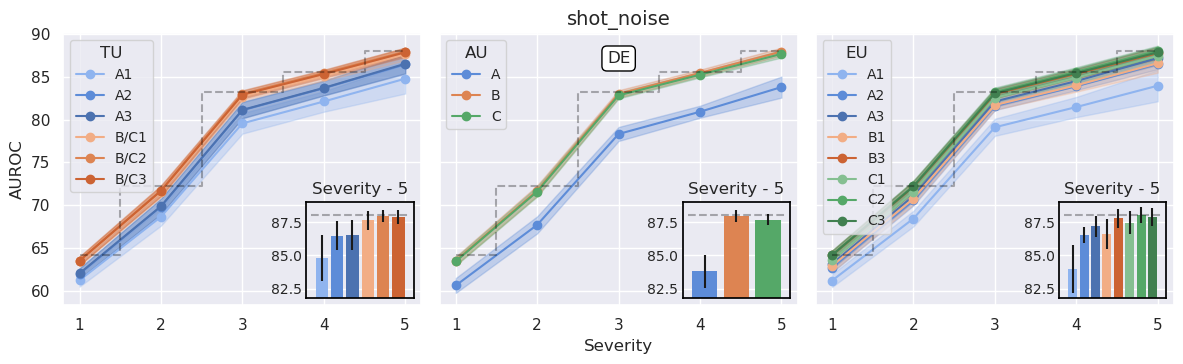

snow
torch.Size([5, 5, 26])


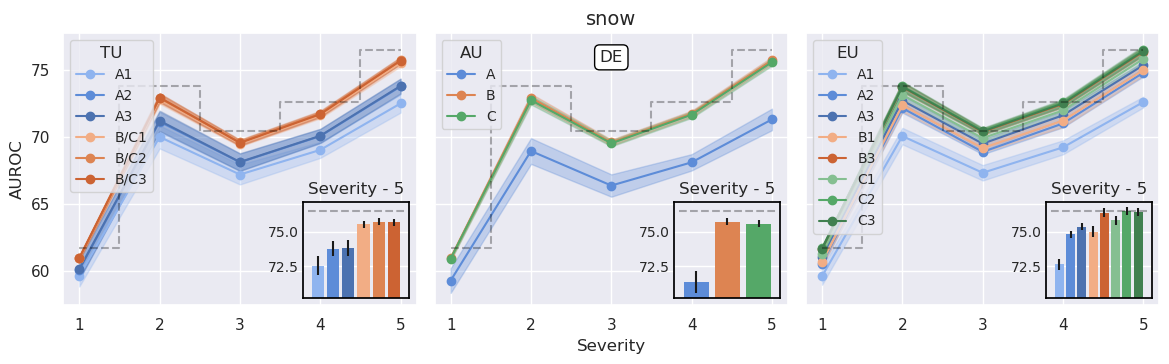

zoom_blur
torch.Size([5, 5, 26])


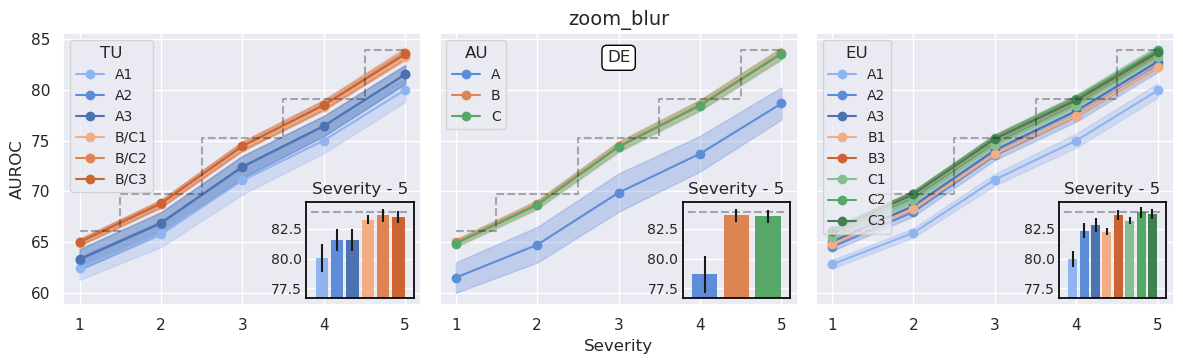

In [47]:
for c in range(n_corruptions):
    print(corruptions[c])
    plot(all_perfs[c], corruptions[c])# , f"cifar10-c_{method}_{model}_{metric.__name__}_{corruptions[c]}")